In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import os

current_dir = os.getcwd()
phrase = "QuantitativeFinance"
target_path = current_dir.split(phrase)[0] + phrase
os.chdir(target_path)
print(os.getcwd())

np.set_printoptions(suppress=True)

from functions import eq_option_pricing_binomial_tree

%load_ext autoreload
%autoreload 1


c:\OneDrive\Pulpit\QuantitativeFinance


In [ ]:
# Sources

# # Hull, Options, Futures and Other Derivatives, chapter 13
# The idea is based on Cox, Ross and Rubinstein paper published in 1979

In [ ]:
# Let's assume we have one period binomial tree and construct a portfolio consisting of:
# - one call option with underlying X
# - delta shares of X

# We suppose that X price (s0) can:
# - go up (to level s0*u, u > 1 -> % price change = (u - 1)%), let's denote payoff as f_u 
# - go down (to level s0*d, d < 1 -> % price change = (d - 1)%), let's denote payoff as f_d
# - current payoff is denoted as f

# We want out portfolio to be riskless, providing the same value regardless of X price so:
#   s0 * u * delta - f_u = s0 * d * delta - f_d   ->   delta = (f_u - f-d) / (s0 * u - s0 * d)

# Then we do not want to have an arbitrage opportunity so the value of the portfolio must be:
#   (s0 * u * delta - f_u) * e^(-rT)

# While cost of setting this portfolio is:
#   s0 * delta - f

# So the formula for value of the portfolio is:
#   s0 * delta - f = (s0 * u * delta - f_u) * e^(-rT)

# After doing some transformation, we can get final formula:
#   f = e^(-rT) * (p * f_u + (1 - p) * f_d)
# where p = (e^(rT) - d) / (u - d) and can be interpreted as probability of an up movement in 
# risk-neutral world

# Consequently, E(S_T) = p*s0*u + (1-p)*s0*d
# As p = (e^(rT) - d) / (u - d)   ->   E(S_T) = s0*e^(rT) - stock price grows at the risk-free
# rate on average 


In [ ]:
# Generalized version of the model

# f = e^(-r*dt) * (p*f_u + (1-p)*f_d)
# Where p = (e^(r*dt) - d) / (u - d)

# When there are 2 nodes:
# f = e^(-2*r*dt) * (p^2*f_uu + 2*p*(1-p)*f_ud + (1-p)^2*f_dd)
# Where: 
# f_uu - value of an option on the last node when there was up and up move
# f_ud - value of an option on the last node when there was up and down move
# f_dd - value of an option on the last node when there was down and down move

# Parameters u and d have to be matched to volatility of an underlying
# During timestep dt there is probability p that price goes up and (1-p) that goes down
# As we need to match volatility, we can derive from definition of variance (E(X^2) - (E(X))^2),
# as E(X) = p*(u-1) + (1-p)*(d-1), the equation:
# e^(r*dt) * (u+d) - ud - e^(2*r*dt) = sigma^2*dt

# Using series expansion we got:
# u = e^(sigma * sqrt(dt))
# d = e^(-sigma * sqrt(dt))


### Binomial tree price

In [2]:
S = 100
K = 110
T = 1.0
r = 0.1
sigma = 0.3
N = 1024

price, paths = eq_option_pricing_binomial_tree(S, K, T, r, sigma, N)


### Price from Black-Scholes-Merton formula

In [ ]:
d1 = (np.log(S/K) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))  # TODO: prepare function that calculates it
d2 = d1 - sigma * np.sqrt(T)
c = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

print(f'Black-Scholes-Merton analytical option price: {c:.6f}')
print(f'Binomial tree with {N} time steps option price: {price:.6f}')


Black-Scholes-Merton analytical option price: 12.131029
Binomial tree with 1024 time steps option price: 12.129264


In [9]:
time_steps = 2**12
n_range = np.linspace(1, time_steps, time_steps)
v_lst = []

for n in n_range:
    price, paths = eq_option_pricing_binomial_tree(S, K, T, r, sigma, n)
    v_lst.append(price)
    

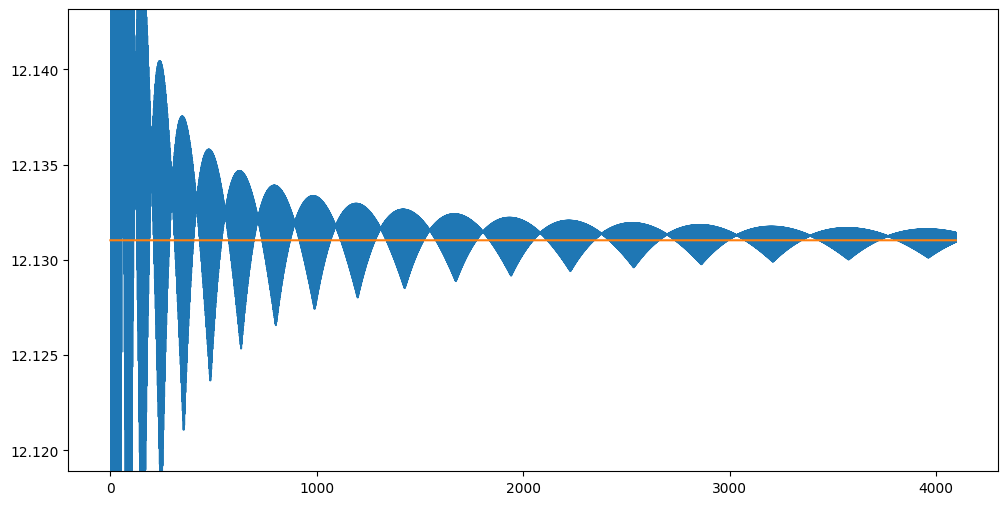

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(n_range, v_lst)
plt.plot(n_range, np.full_like(v_lst, c))
plt.ylim(c * 0.999, c * 1.001)
plt.show()


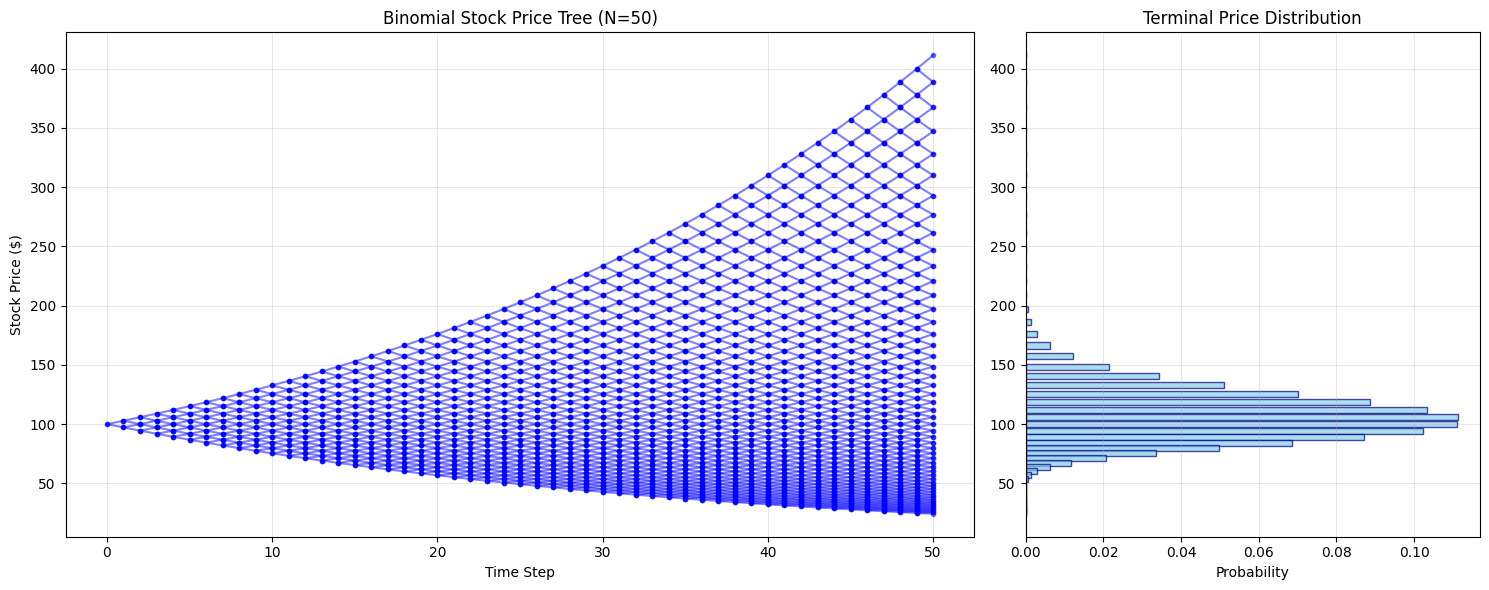

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb

def plot_binomial_tree_with_dist(S, T, r, sigma, N):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    
    # 1. Generate Tree Data
    tree = []
    for i in range(N + 1):
        # Calculate prices at step i (i+1 nodes)
        prices = S * (u ** np.arange(i, -1, -1)) * (d ** np.arange(0, i + 1, 1))
        tree.append(prices)
    
    # 2. Calculate Terminal Probabilities
    # k is number of up moves. tree[N][0] is k=N, tree[N][N] is k=0
    k_vals = np.arange(N, -1, -1) 
    probs = comb(N, k_vals) * (p**k_vals) * ((1-p)**(N-k_vals))
    
    # 3. Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [2, 1]})

    # Left Plot: The Tree
    for i in range(N):
        for j in range(len(tree[i])):
            # Connect current node to 'up' and 'down' nodes in next step
            ax1.plot([i, i+1], [tree[i][j], tree[i+1][j]], 'b-o', markersize=3, alpha=0.5)
            ax1.plot([i, i+1], [tree[i][j], tree[i+1][j+1]], 'b-o', markersize=3, alpha=0.5)

    ax1.set_title(f"Binomial Stock Price Tree (N={N})")
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Stock Price ($)")
    ax1.grid(True, alpha=0.3)

    # Right Plot: The Distribution
    terminal_prices = tree[N]
    ax2.barh(terminal_prices, probs, height=(terminal_prices.max()-terminal_prices.min())/(N*1.5), 
             color='skyblue', edgecolor='navy', alpha=0.7)
    ax2.set_title("Terminal Price Distribution")
    ax2.set_xlabel("Probability")
    ax2.set_ylim(ax1.get_ylim()) # Keep Y-axis aligned with the tree
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Example execution
plot_binomial_tree_with_dist(S=100, T=1, r=0.05, sigma=0.2, N=50)